In [1]:
import torch
import torch.nn as nn
import numpy as np

import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 4

# Transformations: normalize images to have values between -1 and 1
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the EMNIST dataset (Balanced split)
train_dataset = datasets.MNIST(
    root='./data',
    # split='balanced',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root='./data',
    # split='balanced',
    train=False,
    download=True,
    transform=transform
)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

total_labels = np.unique([x[1] for x in test_dataset]).shape[0]
np.random.seed(0)
labels = np.arange(total_labels).astype(int)
shuffled_labels = np.arange(total_labels)
np.random.shuffle(shuffled_labels)

NUM_LABELS = 6

selected_labels = shuffled_labels[:NUM_LABELS]
label_map = {i:j for i,j in zip(selected_labels, labels[:NUM_LABELS])}


def map_labels(batch_labels, label_map):

    new_labels = np.asarray([label_map[int(l)] for l in batch_labels])

    new_labels = torch.from_numpy(new_labels).to(dtype=torch.long)

    return new_labels

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, NUM_LABELS) 

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model, loss function, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def train(save_name='mnist_cnn.pth'):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        total_samples = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            sel_indices = [ii for ii, l in enumerate(labels) if int(l) in selected_labels]

            images = images[sel_indices]
            labels = labels[sel_indices]

            labels = map_labels(labels, label_map).to(device)

            total_samples += len(labels)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        avg_loss = total_loss / total_samples
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f} - Total samples: {total_samples}')

    # Save the trained model after training
    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
               save_name)
    print(f'Model saved as {save_name}')

# Evaluation loop
def evaluate(model, device='cuda'):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            sel_indices = [ii for ii, l in enumerate(labels) if int(l) in selected_labels]
            images = images[sel_indices]
            labels = labels[sel_indices]
            labels = map_labels(labels, label_map).to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')

# Function to load the model
def load_model(filepath='mysterious_model.pth', device='cpu'):
    local_model = SimpleCNN().to(device)
    checkpoint = torch.load(filepath)
    local_model.load_state_dict(checkpoint['model_state_dict'])
    print(f'Model loaded from {filepath}')
    return local_model.eval()

Using device: cuda


In [2]:
# Main execution
if __name__ == '__main__':
    # Train and save the model
    savename = 'mysterious_model.pth'
    train(save_name=savename)
    
    # Load the model and evaluate again (optional)
    model = load_model(savename, device='cpu')
    evaluate(model, device='cpu')    

Model loaded from mysterious_model.pth
Accuracy on test set: 99.46%


In [4]:
# write the flag
with open('flag.txt', 'w') as fp:
    classes = ','.join([str(l) for l in selected_labels])
    fp.write(f'ictf{{{classes}}}')

In [127]:
# create the test data
selected_test_samples = {l:[] for l in range(total_labels)}

for images, labels in test_loader:

    for ii, l in enumerate(labels):

        if len(selected_test_samples[int(l)]) >= 10:
            continue
        selected_test_samples[int(l)].append(images[ii].cpu().squeeze().numpy())

for l in selected_test_samples:
    selected_test_samples[l] = np.asarray(selected_test_samples[l])

all_test_samples = []
all_test_labels = []
for l,k in selected_test_samples.items():
    all_test_samples.extend(k)
    all_test_labels.extend([l]*len(k))

all_test_samples = np.asarray(all_test_samples)
all_test_labels = np.asarray(all_test_labels)

shuffle_idx = np.arange(len(all_test_labels))
np.random.shuffle(shuffle_idx)

all_test_samples = all_test_samples[shuffle_idx]
all_test_labels = all_test_labels[shuffle_idx]
np.save('images.npy', all_test_samples)
np.save('labels.npy', all_test_labels)

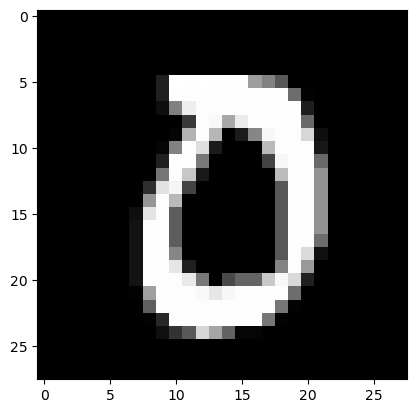

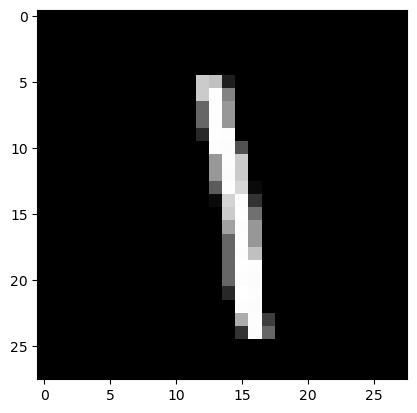

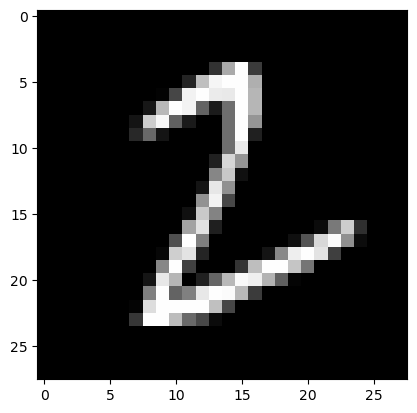

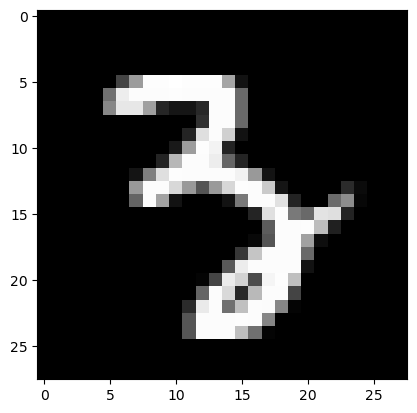

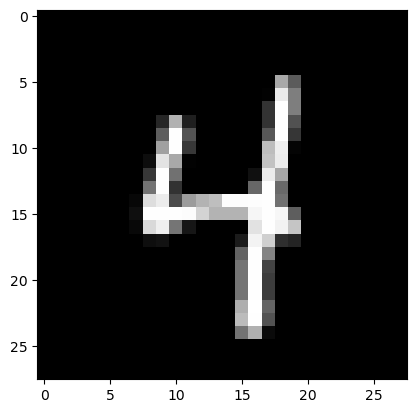

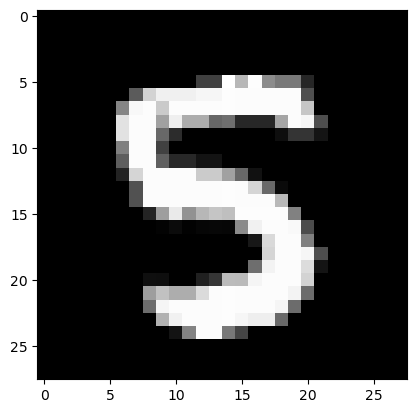

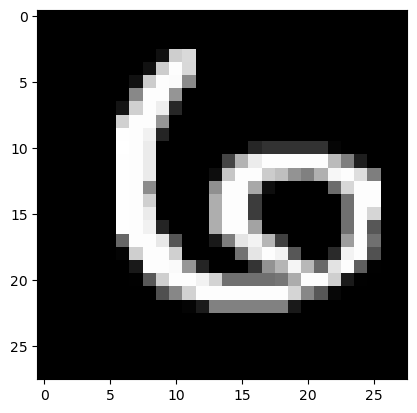

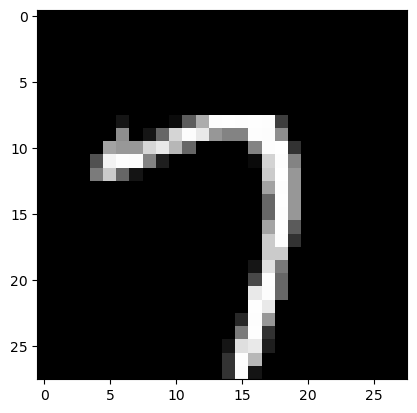

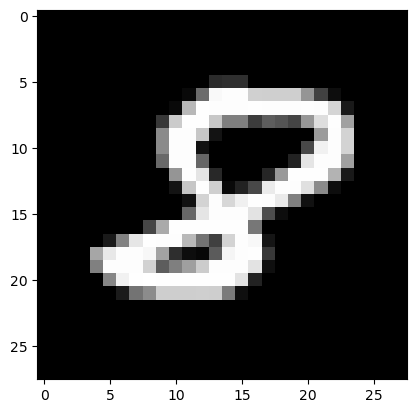

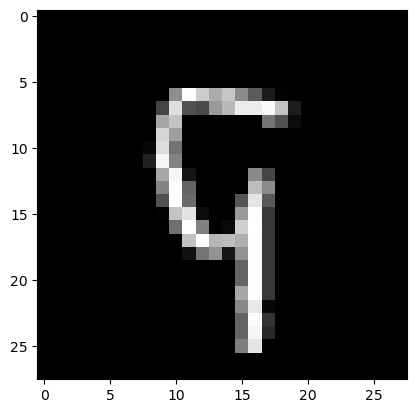

In [141]:
# sanity check
import matplotlib.pyplot as plt

for class_idx in np.unique(all_test_labels):
    for i,l in zip(all_test_samples, all_test_labels):
        if l == class_idx:
            img = (i*255).astype(np.uint8)
            plt.figure()
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            break